In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

width, height = 10, 5
mpl.rcParams['figure.figsize'] = [width, height]


In [2]:
from sklearn import svm
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection

from utility_fns import form_last_n_games
from utility_fns import make_train_val_test


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
basedir = os.path.dirname(os.getcwd())
data = os.path.join(basedir, 'data', 'derived', 'cleaned_matches.csv')
cleaned_matches = pd.read_csv(data)


In [5]:
cleaned_matches.Date = pd.to_datetime(cleaned_matches.Date)
cleaned_matches.sort_values(by='Date', inplace=True, ascending=True)
cleaned_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26122 entries, 0 to 26121
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             26122 non-null  object        
 1   Date            26122 non-null  datetime64[ns]
 2   Home/Away       26122 non-null  object        
 3   Opponent        26122 non-null  object        
 4   Score           26122 non-null  object        
 5   W/L/T           26122 non-null  object        
 6   Overtime        948 non-null    object        
 7   Location        26122 non-null  object        
 8   Venue           26122 non-null  object        
 9   Attendance      26098 non-null  float64       
 10  Notes           1061 non-null   object        
 11  Opponent Code   26122 non-null  object        
 12  Team            26122 non-null  object        
 13  Team Code       26122 non-null  object        
 14  Team Score      25942 non-null  float64       
 15  Op

## Train to classify based on the last-n-games a team played

In [6]:
x_cols = [
    'Team Code',
    'Opponent Code'
]
lookup_x_cols = [
    'Team Score',
    'Opponent Score',
    'Opponent Code'
]
y_cols = [
    'Class'
]

played_matches = cleaned_matches.dropna(
    axis=0, how='any', subset=x_cols + y_cols + lookup_x_cols).copy()

played_matches['Class'].where(
    played_matches['Class'] > 0, other=0, inplace=True)
played_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25942 entries, 0 to 26121
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             25942 non-null  object        
 1   Date            25942 non-null  datetime64[ns]
 2   Home/Away       25942 non-null  object        
 3   Opponent        25942 non-null  object        
 4   Score           25942 non-null  object        
 5   W/L/T           25942 non-null  object        
 6   Overtime        948 non-null    object        
 7   Location        25942 non-null  object        
 8   Venue           25942 non-null  object        
 9   Attendance      25918 non-null  float64       
 10  Notes           1051 non-null   object        
 11  Opponent Code   25942 non-null  object        
 12  Team            25942 non-null  object        
 13  Team Code       25942 non-null  object        
 14  Team Score      25942 non-null  float64       
 15  Op

In [7]:
last_n_matches, new_columns = form_last_n_games(
    played_matches, 5, lookup_x_cols, x_cols)

.................................................
 Done


In [8]:
X = pd.concat([last_n_matches[x_cols], last_n_matches[new_columns]], axis=1)
y = last_n_matches[y_cols]

numeric_columns = X.columns[X.columns.str.contains('Score')]
dummies_columns = X.columns[~X.columns.str.contains('Score')]
print(dummies_columns)
print(numeric_columns)

Index(['Team Code', 'Opponent Code', 'Team Code_p_Opponent Code',
       'Opponent Code_p_Opponent Code', 'Team Code_pp_Opponent Code',
       'Opponent Code_pp_Opponent Code', 'Team Code_ppp_Opponent Code',
       'Opponent Code_ppp_Opponent Code', 'Team Code_pppp_Opponent Code',
       'Opponent Code_pppp_Opponent Code', 'Team Code_ppppp_Opponent Code',
       'Opponent Code_ppppp_Opponent Code'],
      dtype='object')
Index(['Team Code_p_Team Score', 'Opponent Code_p_Team Score',
       'Team Code_pp_Team Score', 'Opponent Code_pp_Team Score',
       'Team Code_ppp_Team Score', 'Opponent Code_ppp_Team Score',
       'Team Code_pppp_Team Score', 'Opponent Code_pppp_Team Score',
       'Team Code_ppppp_Team Score', 'Opponent Code_ppppp_Team Score',
       'Team Code_p_Opponent Score', 'Opponent Code_p_Opponent Score',
       'Team Code_pp_Opponent Score', 'Opponent Code_pp_Opponent Score',
       'Team Code_ppp_Opponent Score', 'Opponent Code_ppp_Opponent Score',
       'Team Code_ppp

In [9]:
X.head()

,Team Code,Opponent Code,Team Code_p_Team Score,Opponent Code_p_Team Score,Team Code_pp_Team Score,Opponent Code_pp_Team Score,Team Code_ppp_Team Score,Opponent Code_ppp_Team Score,Team Code_pppp_Team Score,Opponent Code_pppp_Team Score,...,Team Code_p_Opponent Code,Opponent Code_p_Opponent Code,Team Code_pp_Opponent Code,Opponent Code_pp_Opponent Code,Team Code_ppp_Opponent Code,Opponent Code_ppp_Opponent Code,Team Code_pppp_Opponent Code,Opponent Code_pppp_Opponent Code,Team Code_ppppp_Opponent Code,Opponent Code_ppppp_Opponent Code
12,buf,cle,6.0,6.0,0.0,28.0,21.0,0.0,0.0,0.0,...,buf,buf,buf,cin,det,cle,buf,buf,cle,cle
19,gb,chic,16.0,16.0,3.0,3.0,3.0,3.0,6.0,0.0,...,gb,gb,chic,chic,gb,gb,gb,chic,min,min
23,min,chic,3.0,3.0,6.0,3.0,7.0,16.0,0.0,3.0,...,min,min,gb,chic,min,gb,chic,chic,min,gb
25,chic,buf,0.0,7.0,3.0,0.0,3.0,10.0,16.0,6.0,...,chic,buf,min,chib,chic,cle,gb,buf,chic,buf
24,buf,chic,9.0,9.0,7.0,0.0,0.0,3.0,10.0,3.0,...,buf,buf,buf,chic,chib,min,cle,chic,buf,gb


In [27]:
def dataset_transformer():
    return ColumnTransformer([('scaler', StandardScaler(), numeric_columns), ('one-hot', OneHotEncoder(handle_unknown='ignore'), dummies_columns)])

dataset_transformer().fit(X, y).transformers

[('scaler',
  StandardScaler(),
  Index(['Team Code_p_Team Score', 'Opponent Code_p_Team Score',
         'Team Code_pp_Team Score', 'Opponent Code_pp_Team Score',
         'Team Code_ppp_Team Score', 'Opponent Code_ppp_Team Score',
         'Team Code_pppp_Team Score', 'Opponent Code_pppp_Team Score',
         'Team Code_ppppp_Team Score', 'Opponent Code_ppppp_Team Score',
         'Team Code_p_Opponent Score', 'Opponent Code_p_Opponent Score',
         'Team Code_pp_Opponent Score', 'Opponent Code_pp_Opponent Score',
         'Team Code_ppp_Opponent Score', 'Opponent Code_ppp_Opponent Score',
         'Team Code_pppp_Opponent Score', 'Opponent Code_pppp_Opponent Score',
         'Team Code_ppppp_Opponent Score', 'Opponent Code_ppppp_Opponent Score'],
        dtype='object')),
 ('one-hot',
  OneHotEncoder(handle_unknown='ignore'),
  Index(['Team Code', 'Opponent Code', 'Team Code_p_Opponent Code',
         'Opponent Code_p_Opponent Code', 'Team Code_pp_Opponent Code',
         'Oppone

In [11]:
X.describe()

,Team Code_p_Team Score,Opponent Code_p_Team Score,Team Code_pp_Team Score,Opponent Code_pp_Team Score,Team Code_ppp_Team Score,Opponent Code_ppp_Team Score,Team Code_pppp_Team Score,Opponent Code_pppp_Team Score,Team Code_ppppp_Team Score,Opponent Code_ppppp_Team Score,Team Code_p_Opponent Score,Opponent Code_p_Opponent Score,Team Code_pp_Opponent Score,Opponent Code_pp_Opponent Score,Team Code_ppp_Opponent Score,Opponent Code_ppp_Opponent Score,Team Code_pppp_Opponent Score,Opponent Code_pppp_Opponent Score,Team Code_ppppp_Opponent Score,Opponent Code_ppppp_Opponent Score
count,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000,25806.000000
mean,20.606564,20.497016,20.467721,20.619740,20.649384,20.423119,20.391692,20.666860,20.601643,20.451445,20.523173,20.562815,20.614663,20.464117,20.428854,20.634155,20.660467,20.385492,20.408510,20.627257
std,10.570109,10.562621,10.543124,10.597195,10.594489,10.543052,10.542007,10.596455,10.575879,10.565614,10.546515,10.597641,10.600641,10.542176,10.545444,10.597746,10.585354,10.550893,10.543692,10.598442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
50%,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
75%,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,28.000000
max,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000


In [12]:
y.head()

,Class
12,1
19,0
23,0
25,1
24,0


In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = make_train_val_test(
    X, y, test_pct=0.2, val_pct=0.2, random_state=0
)

# y_train = y_train.ravel()
# y_val = y_val.ravel()
# y_test = y_test.ravel()

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(15483, 32) (15483, 1)
(5161, 32) (5161, 1)
(5162, 32) (5162, 1)


Evaluating linear kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluating linear kernel for C=0.31622776601683794


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating linear kernel for C=10.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


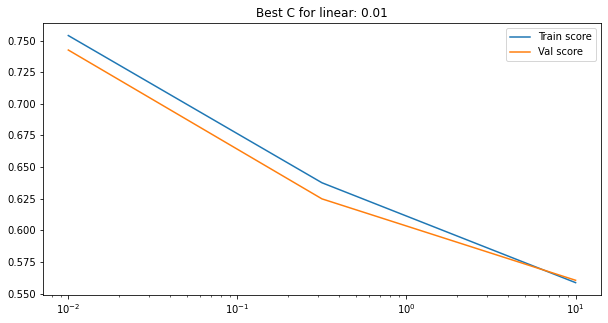

Evaluating poly kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluating poly kernel for C=0.31622776601683794


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluating poly kernel for C=10.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


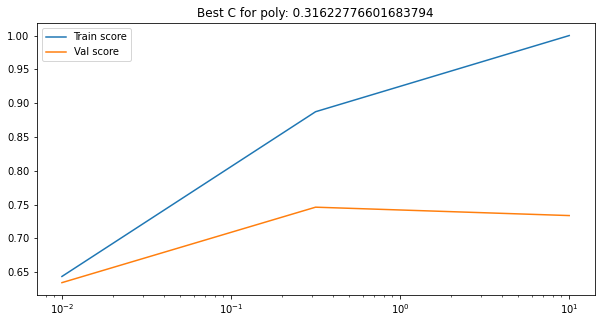

Evaluating rbf kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluating rbf kernel for C=0.31622776601683794


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluating rbf kernel for C=10.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


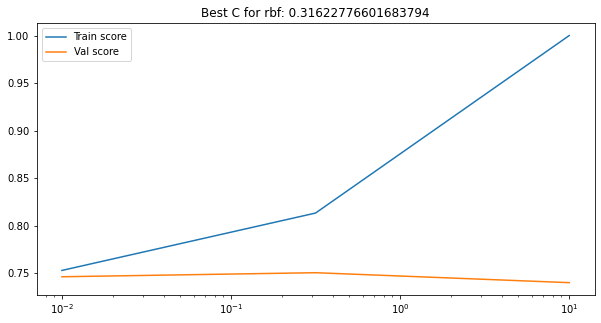

Evaluating sigmoid kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluating sigmoid kernel for C=0.31622776601683794


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating sigmoid kernel for C=10.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


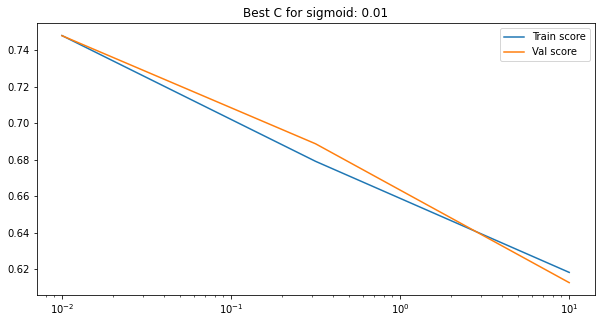

In [15]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    train_scores = []
    val_scores = []
    val_space = np.geomspace(start=0.01, stop=10, num=3)
    for C in val_space:
        print(f"Evaluating {kernel} kernel for C={C}")
        model = make_pipeline(dataset_transformer(), svm.SVC(C=C, max_iter=10_000, kernel=kernel))

        model.fit(X_train, y_train.values.ravel())
        train_scores.append(model.score(X_train, y_train.values.ravel()))
        val_scores.append(model.score(X_val, y_val.values.ravel()))

    plt.title(f'Best C for {kernel}: {val_space[np.argmax(val_scores)]}')
    plt.plot(val_space, train_scores, label='Train score')
    plt.plot(val_space, val_scores, label='Val score')
    # plt.ylim(0, 1.1)
    plt.xscale('log')
    plt.legend()
    plt.show()


In [16]:
y_pred = model.predict(X_test)
precision, recall, fbeta_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

In [29]:
best_config = []
best_score = 0
best_fit_config = []
best_fit_score = 0
for estimator in [DecisionTreeClassifier(max_leaf_nodes=3), DecisionTreeClassifier(max_leaf_nodes=5), DecisionTreeClassifier(max_leaf_nodes=62), DecisionTreeClassifier(max_leaf_nodes=124)]:
  for nestimators in [10, 31, 62, 93, 124]:
    for nsamples in [10, 20, 30, 50]:
      clf = make_pipeline(dataset_transformer(), BaggingClassifier(base_estimator=estimator, n_estimators=nestimators, max_samples=nsamples))
      clf.fit(X_train, y_train.values.ravel())
      
      score = clf.score(X_val, y_val.values.ravel())
      if(score > best_score):
        best_config = [estimator, nestimators, nsamples]
        best_score = score
      
      score = clf.score(X_train, y_train)
      if(score > best_fit_score):
        best_fit_config = [estimator, nestimators, nsamples]
        best_fit_score = score
        
      print(end='.')

................................................................................

In [30]:
print(f"Best validation: {best_score}, {best_config}")
print(f"Best training: {best_fit_score}, {best_fit_config}")

Best validation: 0.7378415035845767, [DecisionTreeClassifier(max_leaf_nodes=5), 124, 50]
Best training: 0.73900406897888, [DecisionTreeClassifier(max_leaf_nodes=5), 124, 50]


In [31]:
clf = make_pipeline(dataset_transformer(), DecisionTreeClassifier())
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.7473357876380546

In [ ]:
plt.hist(clf.predict_proba(X_test))

array([[1., 0.]])

In [46]:
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

In [48]:
Cs = np.geomspace(0.01, 15, num=75)
scores = []
for c in Cs:
    model = make_pipeline(dataset_transformer(), svm.LinearSVC(dual=False, C=c, max_iter=100_000))
    scores.append(cross_val_score(
        model, X_cv, y_cv.values.ravel(), cv=5))
    print(end='.')


...........................................................................

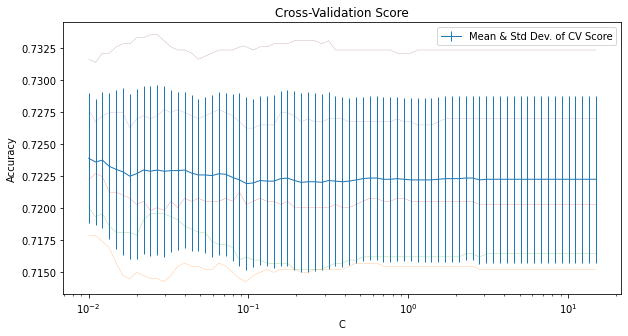

In [49]:
x = Cs
plt.errorbar(x, np.mean(scores,axis=1), np.std(scores,axis=1), label='Mean & Std Dev. of CV Score', linewidth=1)
plt.plot(x, np.sort(scores, axis=1), linewidth=0.2)
plt.legend()
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Score')
plt.show()

In [50]:
print('Maximum mean:', np.max(np.mean(scores,axis=1)))
print('Corresponding std deviation:', np.std(scores,axis=1)[np.argmax(np.mean(scores,axis=1))])
print('C:',Cs[np.argmax(np.mean(scores,axis=1))])

Maximum mean: 0.7238909040047611
Corresponding std deviation: 0.0050817615459196296
C: 0.01


In [51]:
print('Minimum std deviation:', np.min(np.std(scores,axis=1)))
print('Corresponding mean:', np.mean(scores,axis=1)[np.argmin(np.std(scores,axis=1))])
print('C:',Cs[np.argmin(np.std(scores,axis=1))])

Minimum std deviation: 0.004965350097015623
Corresponding mean: 0.723600229798307
C: 0.011038756465634198


In [52]:
best_mean_cs = np.flip(np.argsort(np.mean(scores,axis=1)))
best_std_cs = np.argsort(np.std(scores,axis=1))

In [56]:
# Do some random perturbation of the Cs
scores = []

Cs_to_examine = np.unique(np.concatenate(
    (Cs[best_mean_cs[:5]], Cs[best_std_cs[:5]])))
Cs_to_examine = np.unique(np.concatenate([Cs_to_examine, np.abs(Cs_to_examine + np.random.normal(scale=0.2,size=len(Cs_to_examine)))]))

for c in Cs_to_examine:
    model = make_pipeline(dataset_transformer(), svm.LinearSVC(dual=False, C=c, max_iter=100_000))
    
    scores.append(cross_val_score(
        model, X_cv, y_cv.values.ravel(), cv=100, n_jobs=-1))
    
    print(end='.')

............

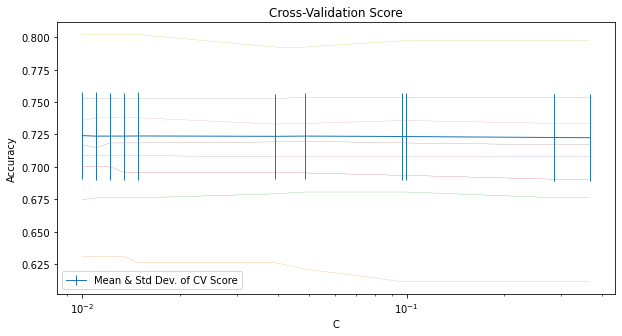

In [57]:
x = Cs_to_examine
quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
plt.errorbar(x, np.mean(scores,axis=1), np.std(scores,axis=1), label='Mean & Std Dev. of CV Score', linewidth=1)
plt.plot(x, np.quantile(scores, quantiles, axis=1).T, linewidth=0.2)
plt.legend()
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Score')
plt.show()

In [58]:
best_mean_idx = np.argmax(np.mean(scores,axis=1))

print(f'Best C={Cs_to_examine[best_mean_idx]} with mean={np.mean(scores,axis=1)[best_mean_idx]}, std={np.std(scores,axis=1)[best_mean_idx]}')

Best C=0.01 with mean=0.7241297312508793, std=0.03340201460025943


In [59]:
# Train the best model.

model = make_pipeline(dataset_transformer(),
    svm.LinearSVC(dual=False, C=Cs_to_examine[best_mean_idx], max_iter=100_000))
model.fit(X_cv, y_cv)
model.score(X_test, y_test)

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7216195273149942

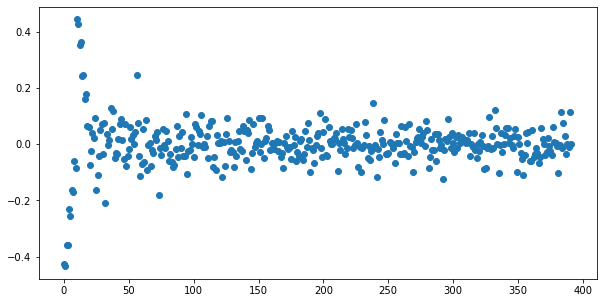

In [60]:
coefs = model[1].coef_[0]
plt.scatter(x=np.arange(len(coefs)),y=coefs)
plt.show()

In [62]:
model.fit(X, y.values.ravel())
confidences = model.decision_function(X)

(array([1.000e+00, 5.000e+00, 1.300e+01, 1.800e+01, 8.600e+01, 1.260e+02,
        2.780e+02, 4.240e+02, 6.270e+02, 8.660e+02, 1.357e+03, 3.342e+03,
        7.330e+03, 5.969e+03, 2.196e+03, 1.051e+03, 8.030e+02, 5.770e+02,
        3.280e+02, 2.120e+02, 1.180e+02, 4.600e+01, 2.100e+01, 7.000e+00,
        5.000e+00]),
 array([-5.06794629, -4.67332178, -4.27869727, -3.88407276, -3.48944825,
        -3.09482374, -2.70019923, -2.30557472, -1.91095021, -1.5163257 ,
        -1.12170119, -0.72707668, -0.33245217,  0.06217234,  0.45679685,
         0.85142136,  1.24604587,  1.64067038,  2.03529489,  2.4299194 ,
         2.82454391,  3.21916842,  3.61379293,  4.00841744,  4.40304195,
         4.79766646]),
 <BarContainer object of 25 artists>)

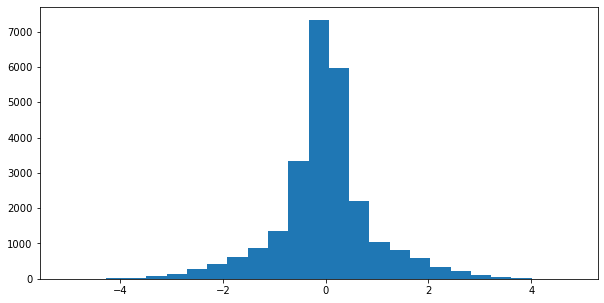

In [63]:
plt.hist(confidences, bins=25)

(array([1.000e+00, 0.000e+00, 4.000e+00, 8.800e+01, 7.820e+02, 2.896e+03,
        5.333e+03, 5.400e+03, 3.387e+03, 2.047e+03, 1.447e+03, 1.204e+03,
        9.180e+02, 7.880e+02, 4.870e+02, 4.000e+02, 2.600e+02, 1.580e+02,
        1.090e+02, 4.100e+01, 2.400e+01, 2.000e+01, 6.000e+00, 4.000e+00,
        2.000e+00]),
 array([-1.81807596, -1.54263507, -1.26719418, -0.99175329, -0.7163124 ,
        -0.44087151, -0.16543062,  0.11001027,  0.38545116,  0.66089205,
         0.93633294,  1.21177383,  1.48721472,  1.76265561,  2.0380965 ,
         2.31353739,  2.58897828,  2.86441917,  3.13986006,  3.41530095,
         3.69074184,  3.96618273,  4.24162362,  4.51706451,  4.7925054 ,
         5.06794629]),
 <BarContainer object of 25 artists>)

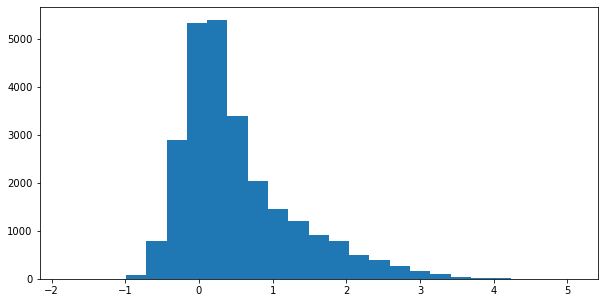

In [64]:
plt.hist(confidences * (2 * y.to_numpy().ravel() - 1), bins=25)